In [1]:
import sys
sys.path.insert(0, '../../')
import math
import numpy as np
import matplotlib.pyplot as plt
from gasp import responses, dataset, get_project_path, analysis
from gasp import train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_simple, create_data_mask, sampling, SSFPParams

Data: 20231106_GASP_PHANTOM data exists
pymapVBVD version 0.5.7
Software version: VB
Scan 1/1, read all mdhs:   0%|          | 0.00/265M [00:00<?, ?B/s]

pymapVBVD version 0.5.7
Software version: VB


pymapVBVD version 0.5.7
Software version: VB


(128, 128, 16, 3)


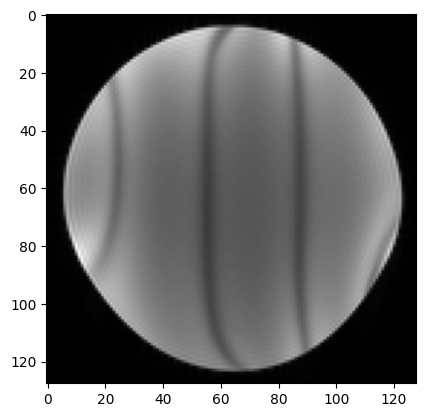

In [2]:
path = get_project_path()
M90 = dataset.load_dataset7a(path)
M = M90[64:192, 64:192, : ,: ,:]
M = np.sqrt(np.sum(np.abs(M)**2, axis=2))
print(M.shape)
plt.imshow(np.abs(M[:,:,10,2]), cmap='gray')
plt.show()

Data: 20231106_GASP_PHANTOM data exists
pymapVBVD version 0.5.7
Software version: VB


pymapVBVD version 0.5.7
Software version: VB


pymapVBVD version 0.5.7
Software version: VB


(128, 128, 16, 3)


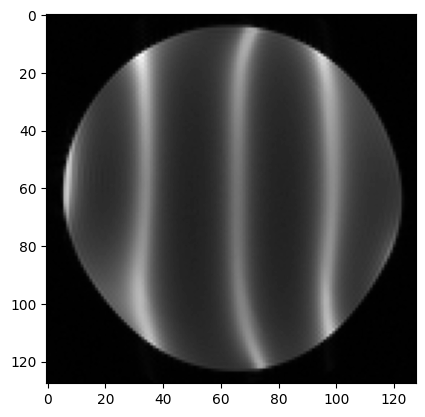

In [3]:
path = get_project_path()
M20 = dataset.load_dataset7b(path)
M = M20[64:192, 64:192, : ,: ,:]
M = np.sqrt(np.sum(np.abs(M)**2, axis=2))
print(M.shape)
plt.imshow(np.abs(M[:,:,10,2]), cmap='gray')
plt.show()

In [17]:
def train_model(D, n = 48, alpha = np.deg2rad(20), T2base = 0.01, T1T2ratio = 5.0):
    width = 128
    height = 1
    gradient = 2 * np.pi
    method = 'affine'

    TRs, PCs = sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])
    params = SSFPParams(n, alpha, TRs, PCs)
    M = simulate_ssfp_simple(width=width, height=height, T1=T1T2ratio * T2base, T2 = T2base, params=params, minTR = np.min(params.TRs), gradient = gradient)
    _, A = train_gasp(M, D, method=method)
    I = run_gasp(M, A, method=method)
    MSE = np.sqrt(np.mean((np.abs(I) - D)**2))

    return A, I, MSE

width = M.shape[1]
D = []
D.append(responses.gaussian(width, bw=0.2, shift=0))
D.append(responses.gaussian(width, bw=0.2, shift=-0.25))
D.append(responses.gaussian(width, bw=0.2, shift=0.25))
D.append(responses.gaussian(width, bw=0.5, shift=0))
D.append(responses.stopband(width, bw=0.2, shift=0))
D.append(responses.stopband(width, bw=0.2, shift=0.25))
D.append(responses.bandpass(width, bw=0.2, shift=0))
D.append(responses.square(width, bw=0.2, shift=0.4))

outputs = []
A = []
MSE = []
for d in D:
    An, output, MSEn = train_model(d, n=48, alpha=np.deg2rad(20), T2base = 0.01, T1T2ratio = 5.0)
    outputs.append(output)
    A.append(An)
    MSE.append(MSEn)


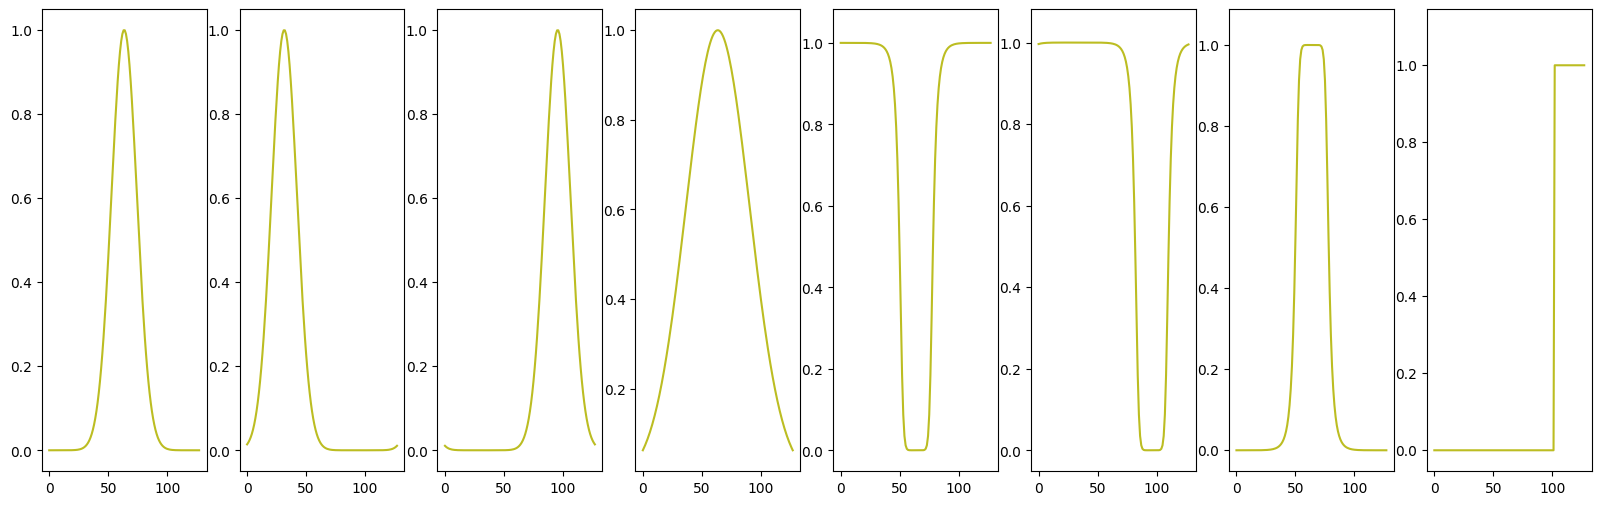

In [19]:
fig, ax = plt.subplots(1, len(D), figsize=(20, 6))
for i, output in enumerate(outputs):
    ax[i].plot(np.abs(output))
    ax[i].plot(D[i])
plt.show()